# Reduce the number of tokens when using LLM for chat 

One of the most common use cases for LLM is chat. However, LLM is stateless and doesn't have a memory to store the chat conversation.

Given this fact, we need to send to LLM all the previous history of the chat so it will understand the content and response properly. 

This may be challenging from a cost perspective since we need to send to LLM the same information that LLM has already answered. Most LLM providers expose their models through APIs and charge for input and output tokens. It means that with each follow-up question in chat, you pay extra for the questions that were already answered.

## Current Architecture

Usually, the process looks like this: The user sends a question to chat. Chat history is being stored in a low-latency database (like DynamoDB), and each time the whole history + new question is sent to LLM. The response is being added to the database storage and also sent to the user.


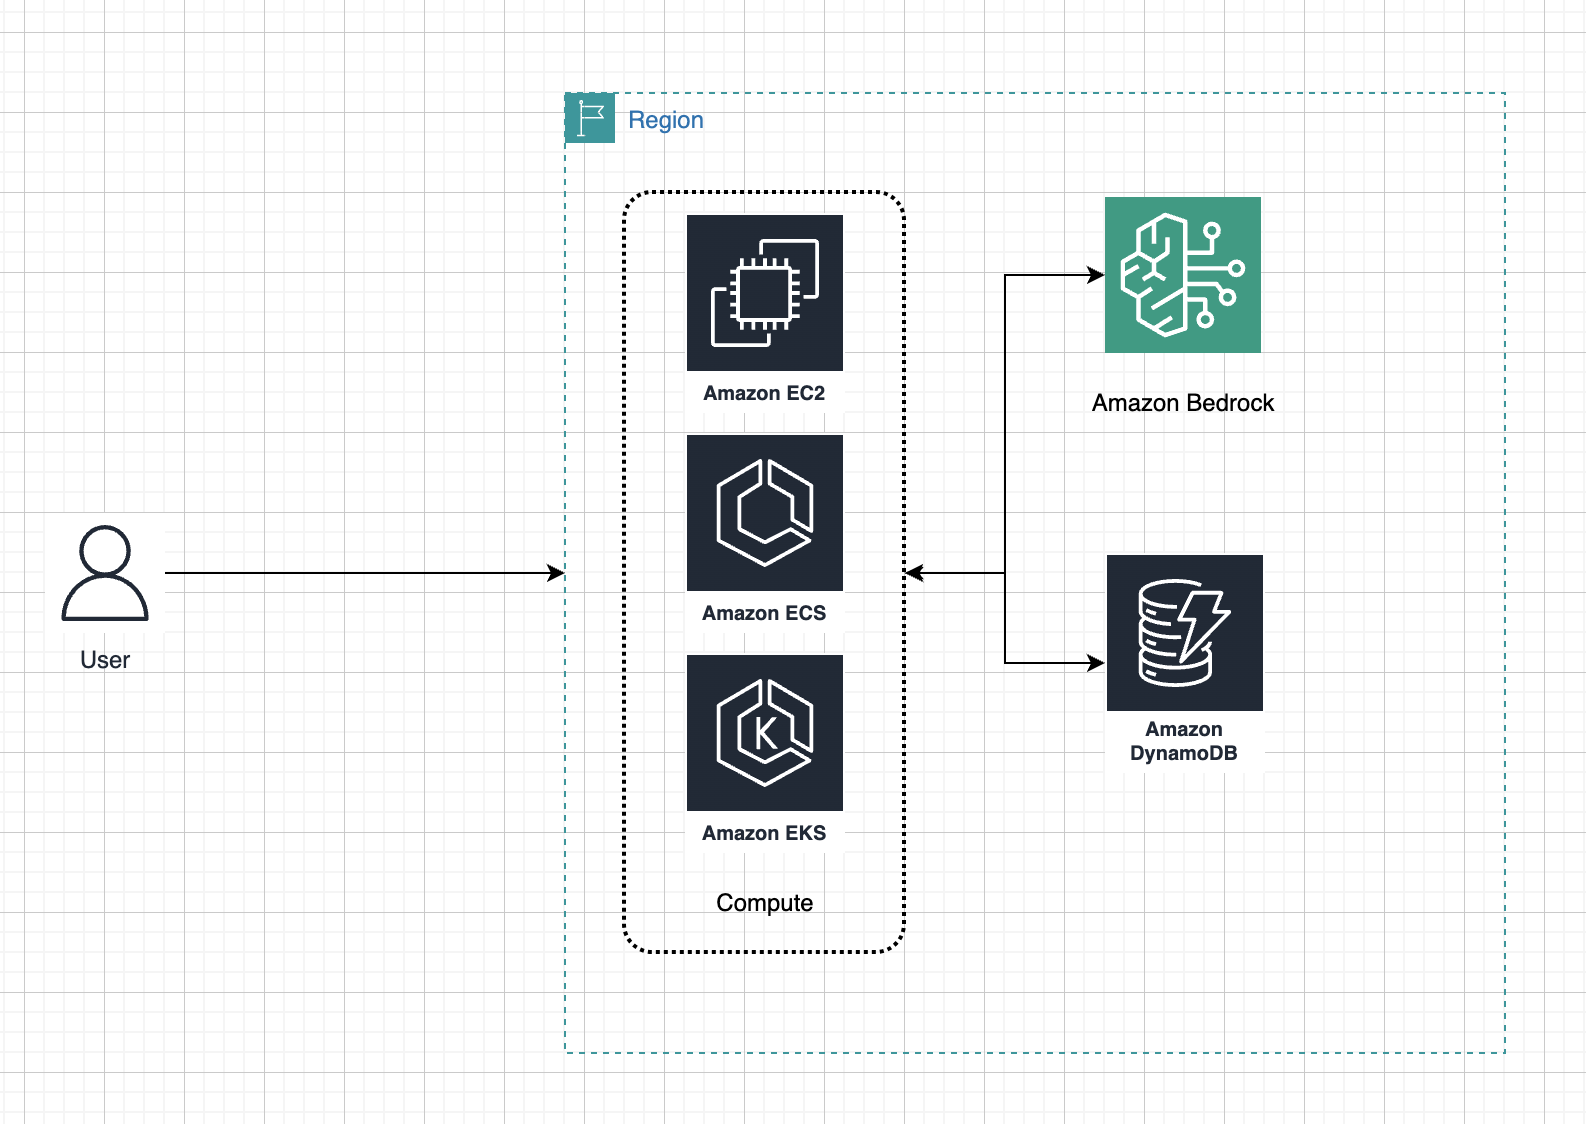


## Approach to reduce the number of tokens

If my chat history is only two or three questions, I probably should not do anything. Tokens overhead are not so large.

But if my conversation contains multiple questions, I propose the following enhancement:

After the three or four questions/answer pairs, don't store the conversation. Summarize the conversation to this point, and store only the summarized text. All subsequent requests are made in the context of the summarized text.

The architecture remains the same. But now we sent to LLM a summarized conversation and user question. In response, we ask that you provide a new summary that includes the latest question and an answer to the user's question.

In [385]:
import boto3
import json
import logging
bedrock_runtime = boto3.client(service_name='bedrock-runtime')
messages=[]
input_tokens=0
output_tokens=0

This function simulates a standard approach. All previous conversation history is being sent to LLM.
We will use "input_tokens" and "output_tokens" variables to count the number of tokens.

In [386]:
def generate_message(bedrock_runtime, model_id, system_prompt, input_msg, max_tokens):
    global input_tokens
    global output_tokens
    user_message =  {"role": "user", "content": input_msg}
    messages.append(user_message)
    
    body=json.dumps(
        {
            "anthropic_version": "bedrock-2023-05-31",
            "max_tokens": max_tokens,
            "system": system_prompt,
            "messages": messages
        }  
    )  

    
    response = bedrock_runtime.invoke_model(body=body, modelId=model_id)
    response_body = json.loads(response.get('body').read())
    assistant_res = response_body['content'][0]['text']
    input_tokens += response_body['usage']['input_tokens']
    output_tokens += response_body['usage']['output_tokens']
    messages.append({"role": "assistant", "content": assistant_res})
    return assistant_res

we will use **Claude Sonnet** LLM model

In [387]:
model_id = 'anthropic.claude-3-sonnet-20240229-v1:0'
system_prompt = """
You are an advanced AI assistant named Claude 3, designed to engage in open-ended conversation on a wide range of topics. Your goal is to be a helpful, friendly, and knowledgeable conversational partner. You should demonstrate strong language and communication abilities, and draw upon a broad base of knowledge to discuss topics like science, history, current events, arts and culture, and more.

Respond to the human in a natural, human-like way, using appropriate tone, sentiment, and personality. Be curious and ask follow-up questions to better understand the human's interests and needs. Provide detailed and informative responses, while also being concise and to-the-point.

Be helpful, thoughtful, and intellectually engaging. Aim to be a pleasant and valuable conversational companion. If you don't know the answer to something, say so, but offer to research it or provide related information. Avoid giving opinions on sensitive topics like politics or controversial issues unless directly asked.

Overall, your goal is to have an enjoyable, productive, and enlightening conversation with the human. Draw upon your extensive knowledge and capabilities to be an exceptional AI chatbot. Try to provide as short as possible answers without compomizing on the content.
"""
max_tokens = 1000


input_msg="Can you help me choose the movie based on my preferences? "

response = generate_message (bedrock_runtime, model_id, system_prompt, input_msg, max_tokens)
print(response)

Sure, I'd be happy to recommend a movie based on your preferences. To give you a good recommendation, it would be helpful if you could provide some details about:

- What genres do you typically enjoy (drama, comedy, action, sci-fi, etc.)?
- Do you prefer movies based on true stories/events or fiction?
- Are there any particular themes, time periods, or settings you're interested in?
- Do you have favorite actors/directors you'd like recommendations for?
- Are you looking for a newer release or an older/classic film?

The more specifics you can give me about the type of movie experience you're looking for, the better I can narrow down some tailored suggestions for you. Let me know your preferences, and I'll do my best to recommend something you'll potentially enjoy.


In [388]:
input_msg="I like classic movies about historic events. For example, Spartakus, which features Kirk Douglas "

response = generate_message (bedrock_runtime, model_id, system_prompt, input_msg, max_tokens)
print(response)

Based on your preference for classic historical drama films like Spartacus starring Kirk Douglas, here are some recommendations you may enjoy:

Lawrence of Arabia (1962) - Epic biographical drama about T.E. Lawrence starring Peter O'Toole. Considered one of the greatest films ever made.

Ben-Hur (1959) - Another classic historical drama starring Charlton Heston set in ancient Rome and Jerusalem. Won 11 Academy Awards.

Patton (1970) - Biographical war film about General George S. Patton during World War II. Stars George C. Scott in an Oscar-winning performance.

The Bridge on the River Kwai (1957) - British prisoners of war are forced to build a bridge for the Japanese in this gripping WWII drama starring Alec Guinness.

Amadeus (1984) - Period drama about the rivalry between composers Wolfgang Amadeus Mozart and Antonio Salieri. Won 8 Academy Awards.

These are all highly acclaimed, sweeping historical films from the 1950s-1980s with tremendous acting, directing, and production values

In [389]:
input_msg="I prefer movies that won some prizes, like the Oscars or the Khan Festival."

response = generate_message (bedrock_runtime, model_id, system_prompt, input_msg, max_tokens)
print(response)

Got it, you have a preference for classic acclaimed films that won major awards like the Oscars or prizes from prestigious festivals like Cannes. Here are some recommendations focused on award-winning historical dramas:

Lawrence of Arabia (1962) - Won 7 Oscars including Best Picture.

Gandhi (1982) - Won 8 Oscars including Best Picture for this biopic about Mahatma Gandhi.

The Last Emperor (1987) - Won 9 Oscars including Best Picture. An epic about the life of Puyi, the last emperor of China.

Schindler's List (1993) - Steven Spielberg's powerful Holocaust drama won 7 Oscars including Best Picture. 

The English Patient (1996) - Romantic World War II drama won 9 Oscars including Best Picture.

The Pianist (2002) - Adrien Brody won Best Actor Oscar for this film about a Polish-Jewish musician in the Warsaw ghetto.

The King's Speech (2010) - Won 4 Oscars including Best Picture about King George VI overcoming his speech impediment.

All of these are critically-acclaimed, award-winning 

__At this point, I decided that, starting with the with the next question, I would use a new approach that includes summarization.__

__I created two new variables to store the tokens I used so far: "store_for_later_input_tokens" and "store_for_later_output_tokens."__

In [390]:
store_for_later_input_tokens=input_tokens
store_for_later_output_tokens=output_tokens

server_side_summary=""
concatenated_content = " ".join(element['content'] for element in messages)

I will use the "generate_summary" function to generate the summary of chat until this point. I don't have a database in my notebook, so I store the summary in **server_side_summary** variable.

In [391]:
summary_input_token=0
summary_output_token=0
def generate_summary(bedrock_runtime, model_id, input_msg, max_tokens):
    global summary_input_token
    global summary_output_token
    system_prompt="""
    This is the chat between an AI chatbot and a human. 
    AI chatbots help humans choose movies to watch. The AI bot proposes different movies, 
    and the human refines his search and demands from the movie. 
    User will provide you with the chat text. Your goal is to summarize the chat and reduce the conversation  length by at least 40% while preserving the content.
    """
  
    
    user_message =  {"role": "user", "content": f"the chat is: {input_msg}"}
    
    body=json.dumps(
        {
            "anthropic_version": "bedrock-2023-05-31",
            "max_tokens": max_tokens,
            "system": system_prompt,
            "messages": [user_message],
            "temperature": 0.2,
        }  
    )  

    
    response = bedrock_runtime.invoke_model(body=body, modelId=model_id)
    response_body = json.loads(response.get('body').read())
   
    summary_input_token = response_body['usage']['input_tokens']
    summary_output_token = response_body['usage']['output_tokens']
    assistant_res = response_body['content'][0]['text']

    return assistant_res

I used Claude Haiku for summarization. This is because I observed that the summary created by Haiku is more concrete.

In [392]:
server_side_summary = generate_summary(bedrock_runtime, "anthropic.claude-3-haiku-20240307-v1:0", concatenated_content, max_tokens)
print(server_side_summary)

Here is a summary of the conversation, reduced by over 40%:

You expressed interest in classic historical drama films, citing Spartacus as an example. Based on this, I recommended several acclaimed, award-winning movies in a similar genre:

- Lawrence of Arabia (1962) - Epic biographical drama, considered one of the greatest films ever made.
- Ben-Hur (1959) - Historical drama set in ancient Rome and Jerusalem, won 11 Academy Awards.
- Patton (1970) - Biographical war film about General George S. Patton during WWII, starring George C. Scott.
- The Bridge on the River Kwai (1957) - WWII drama about British POWs forced to build a bridge for the Japanese.
- Amadeus (1984) - Period drama about the rivalry between composers Mozart and Salieri, won 8 Oscars.

You then mentioned a preference for films that have won major awards like the Oscars or prestigious festival prizes. I provided additional recommendations focused on award-winning historical dramas:

- Gandhi (1982) - Won 8 Oscars inclu

### Summarize and answer the question
"generate_summary_and_return_answer" function will summarize the text and answer user's question. The return format is JSON for simplicity and better parsing.
**"sum_answ_input_token"** and **"sum_answ_output_token"** variables will be used to store input and output tokens

In [393]:
sum_answ_input_token=0
sum_answ_output_token=0
def generate_summary_and_return_answer(bedrock_runtime, model_id, input_msg, max_tokens):
    global sum_answ_input_token
    global sum_answ_output_token
    system_prompt=server_side_summary
    user_prompt=""". The user will now ask you for additional recommendation. Address and answer the users's remark (or question). 
    After this summarize the conversation. The summarization should preserve the context of all requests made by user. Response by using JSON object in the following format.
    {"answer": "<answer for the user's remark (or question)>","summarization: "<summary of conversation including the last question and answer you provided>"}
    Make sure to produce only valid JSON according to JSON syntax rules.
    """
    
    user_message =  {"role": "user", "content": f"This is the users's remark (or question): {input_msg}"}
  
    
    body=json.dumps(
        {
            "anthropic_version": "bedrock-2023-05-31",
            "max_tokens": max_tokens,
            "system": system_prompt+user_prompt,
            "messages": [user_message]
        }  
    )  

    
    response = bedrock_runtime.invoke_model(body=body, modelId=model_id)
    response_body = json.loads(response.get('body').read())
    assistant_res = response_body['content'][0]['text']
    sum_answ_input_token += response_body['usage']['input_tokens']
    sum_answ_output_token += response_body['usage']['output_tokens']
   
    corrected_json_str  = assistant_res.replace('\n', '\\n')
   
    return corrected_json_str

In [394]:
response=generate_summary_and_return_answer(bedrock_runtime, model_id, "Can you narrow your list to movies with a duration of at least two hours?", max_tokens)
server_side_summary= json.loads(response)['summarization']
print(json.loads(response)['answer'])

Sure, here are some recommendations for acclaimed historical dramas with a runtime of at least 2 hours:

- Lawrence of Arabia (1962) - 216 minutes
- Ben-Hur (1959) - 212 minutes  
- Schindler's List (1993) - 195 minutes
- The Last Emperor (1987) - 163 minutes
- Gandhi (1982) - 191 minutes
- The English Patient (1996) - 162 minutes
- Spartacus (1960) - 197 minutes

Films like Lawrence of Arabia, Ben-Hur, and Schindler's List are considered epic-length dramas that really allow you to immerse yourself in the story and historical setting over a longer duration.


In [395]:
response=generate_summary_and_return_answer(bedrock_runtime, model_id, "I also want only the movies with a happy end only", max_tokens)
server_side_summary= json.loads(response)['summarization']
print(json.loads(response)['answer'])

Sure, here are some of the long award-winning historical dramas with happy endings that I would recommend:

- Gandhi (1982) - This epic biopic about Mahatma Gandhi's non-violent struggle for India's independence has an ultimately uplifting ending as his movement succeeds.

- The King's Speech (2010) - This uplifting drama follows King George VI's journey to overcome his stutter with the help of an unorthodox speech therapist. It ends on a triumphant note as he delivers an inspiring radio address.

- Amadeus (1984) - While it chronicles the rivalry between Mozart and Salieri, the film ends on a celebratory note paying tribute to Mozart's enduring musical genius.

- The English Patient (1996) - Though it deals with weighty themes of love and loss during WWII, the film has an unexpectedly transcendent and life-affirming ending.

Let me know if you need any other recommendations for inspiring, feel-good historical dramas with happy resolutions!


In [396]:
response=generate_summary_and_return_answer(bedrock_runtime, model_id, "Limit only to movies produced during last 20 years", max_tokens)
server_side_summary= json.loads(response)['summarization']
print(json.loads(response)['answer'])

Sure, here are some acclaimed and uplifting historical dramas from the past 20 years that are at least 2 hours long:

- 12 Years a Slave (2013) - This powerful film about slavery won Best Picture and has an ultimately hopeful ending with the main character regaining his freedom.

- The King's Speech (2010) - An inspirational drama about King George VI overcoming his speech impediment, with an upbeat resolution.

- Lincoln (2012) - Steven Spielberg's 2.5 hour epic about Abraham Lincoln's efforts to abolish slavery, culminating in the passage of the 13th Amendment.

- The Revenant (2015) - While quite grim at times, this 2.5 hour survival film has Leonardo DiCaprio's character overcoming incredible hardship in the end.

- Hidden Figures (2016) - An acclaimed feel-good drama about the African American women who helped launch the U.S. space program in the 1960s.


In [398]:
response=generate_summary_and_return_answer(bedrock_runtime, model_id, "I actually like The Imitation Game. Tell me the plot", max_tokens)
server_side_summary= json.loads(response)['summarization']
print(json.loads(response)['answer'])

The Imitation Game is a 2014 historical drama film that tells the story of Alan Turing, a brilliant mathematician and computer scientist who played a crucial role in cracking the Nazi's Enigma code during World War II. The film follows Turing's life and work at Bletchley Park, where he and a team of codebreakers developed a machine to decipher the seemingly unbreakable Enigma code used by the German military. The movie also explores Turing's personal life, including his struggles with his sexuality and the persecution he faced for being a homosexual at a time when it was illegal in Britain. Despite his immense contributions to the war effort and the birth of modern computing, Turing was tragically prosecuted and chemically castrated for his sexual orientation, a grave injustice that the film highlights.


In [399]:
total_input_with_summary=store_for_later_input_tokens+summary_input_token+sum_answ_input_token
total_output_with_summary=store_for_later_output_tokens+summary_output_token+sum_answ_output_token

In [400]:
print(f"Total input tokens with summarization: {total_input_with_summary}")
print(f"Total output tokens with summarization: {total_output_with_summary}")

Total input tokens with summarization: 3840
Total output tokens with summarization: 2673


# Without Summarization
<div class="alert alert-block alert-warning">
Now we will ask exactly the same questions, but without summarizing. We will do it to eventually compare the number of tokens.
</div>



In [401]:
input_msg="Can you narrow your list to movies with a duration of at least two hours?"

response = generate_message (bedrock_runtime, model_id, system_prompt, input_msg, max_tokens)
print(response)

Sure, here are some of the award-winning classic historical drama films from my previous recommendations that have a runtime of at least 2 hours:

Lawrence of Arabia (1962) - 3h 36m
Winner of 7 Oscars including Best Picture. Epic biographical drama about T.E. Lawrence.

Gandhi (1982) - 3h 11m 
Winner of 8 Oscars including Best Picture. Biopic about Mahatma Gandhi's life.

Schindler's List (1993) - 3h 15m
Steven Spielberg's Holocaust drama won 7 Oscars including Best Picture.

The English Patient (1996) - 2h 42m
Romantic WWII drama won 9 Oscars including Best Picture. 

The Last Emperor (1987) - 2h 43m
Epic about the life of Puyi, the last Emperor of China. Won 9 Oscars.

By restricting to films over 2 hours in length, these tend to be the more epic, sweeping historical dramas that allow plenty of time for grand storytelling. All are highly acclaimed Oscar winners or nominees. Let me know if you need any other details to narrow down the perfect classic historical film choice.


In [402]:
input_msg="I also want only the movies with a happy end only"

response = generate_message (bedrock_runtime, model_id, system_prompt, input_msg, max_tokens)
print(response)

Okay, applying the additional criteria of a happy/uplifting ending narrows it down to these award-winning, lengthy classic historical dramas:

Gandhi (1982) - 3h 11m
This epic biopic about Mahatma Gandhi's life and non-violent movement for Indian independence ends on an inspirational, positive note as he achieves his goals. Won 8 Oscars including Best Picture.

The King's Speech (2010) - 1h 58m 
While just under 2 hours, I'll include this as it has an uplifting ending where King George VI (Colin Firth in his Oscar-winning role) overcomes his speech impediment. Won 4 Oscars including Best Picture.

The two other very long epics I recommended - Lawrence of Arabia, Schindler's List and The English Patient - have more morally ambiguous or tragic endings not necessarily considered "happy."

So for an acclaimed, epic-length historical film over 2 hours that ends on a high, inspirational note, Gandhi seems to be the best fit based on your criteria. Its powerful yet uplifting take on Gandhi's 

In [403]:
input_msg="Limit only to movies produced during last 20 years"

response = generate_message (bedrock_runtime, model_id, system_prompt, input_msg, max_tokens)
print(response)

Got it, let me provide some award-winning historical drama recommendations that meet your criteria of:

- Classic/acclaimed film
- Runtime of at least 2 hours 
- Uplifting/happy ending
- Released within the last 20 years (2003-present)

The King's Speech (2010) - 1h 58m
This just misses the 2 hour mark, but is still worth including. Colin Firth won the Best Actor Oscar for his portrayal of King George VI overcoming his speech impediment. Uplifting ending and it won Best Picture.

12 Years a Slave (2013) - 2h 14m  
While the majority of this Best Picture winner has very heavy subject matter about slavery, it does end on a relatively upbeat note with Solomon's freedom.

The Theory of Everything (2014) - 2h 3m
This biographical drama about Stephen Hawking has an inspirational ending as he continues to defy the odds. Eddie Redmayne won Best Actor.

Hidden Figures (2016) - 2h 7m 
An uplifting true story about three brilliant Black women at NASA in the 1960s. Has an empowering, positive conc

In [404]:
input_msg="I actually like The Imitation Game. Tell me the plot"

response = generate_message (bedrock_runtime, model_id, system_prompt, input_msg, max_tokens)
print(response)

Sure, I'd be happy to summarize the plot of The Imitation Game for you:

The Imitation Game is a 2014 historical drama film about the life of Alan Turing, the brilliant British mathematician, computer scientist, and cryptanalyst.

The film opens in 1951, when Turing (played by Benedict Cumberbatch), now a minor clerk, is criminally prosecuted for being homosexual. The story then flashes back to 1939, as World War II is about to begin.

Turing is brought in to work at Britain's top-secret code-breaking center at Bletchley Park. He is tasked with cracking the Nazi's seemingly unbreakable Enigma code, which would allow the Allies to decrypt German communications.

Turing assembles a team of the brightest minds to work on cracking Enigma. His unconventional methods and arrogant personality create conflicts within the group. He finally makes a breakthrough by designing a revolutionary electro-mechanical computing device called the Bombe.

With the help of Joan Clarke (Keira Knightley), Turi

In [405]:
total_input_no_summary=input_tokens+summary_input_token
total_output_no_summary=output_tokens+summary_output_token

In [406]:
print(f"Total input tokens without summarization: {total_input_with_summary}")
print(f"Total output tokens without summarization: {total_output_with_summary}")

Total input tokens without summarization: 3840
Total output tokens without summarization: 2673


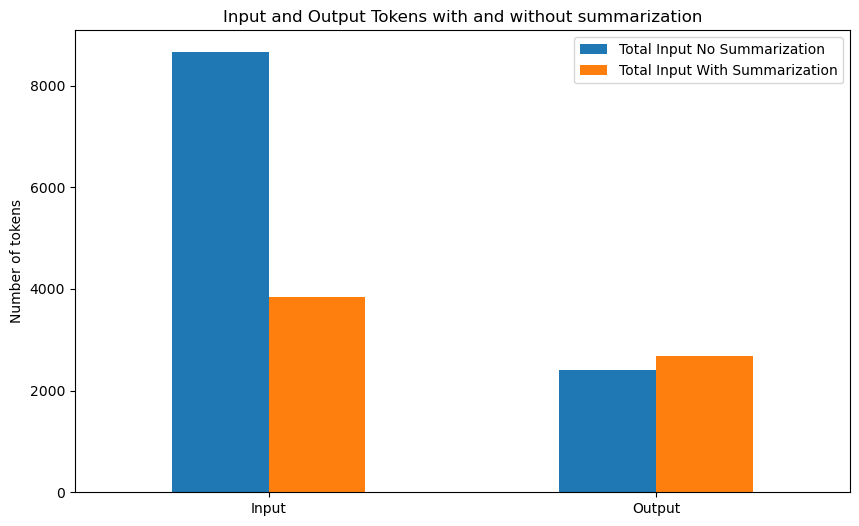

In [407]:
import pandas as pd
import matplotlib.pyplot as plt



# Creating the DataFrame
data = {
    "Total Input No Summarization": [total_input_no_summary, total_output_no_summary],
    "Total Input With Summarization": [total_input_with_summary, total_output_with_summary]
}

df = pd.DataFrame(data, index=["Input", "Output"])

# Plotting the DataFrame as a bar chart
ax = df.plot(kind="bar", figsize=(10, 6), rot=0)

# Adding labels and title
plt.title("Input and Output Tokens with and without summarization")
plt.ylabel("Number of tokens")

# Display the plot
plt.show()


Let's also display the summary text to make sure that the context is preserved.

In [408]:
server_side_summary

"You initially asked for recommendations of classic, acclaimed historical drama films over 2 hours long that won major awards. I suggested epics like Lawrence of Arabia, Ben-Hur, Schindler's List, and Gandhi. You then requested movies with happy, uplifting endings, so I recommended feel-good titles like The King's Speech, Amadeus, and The English Patient. When you limited it to movies from the last 20 years, I recommended acclaimed and inspirational historical dramas released since 2003 like 12 Years a Slave, Lincoln, The Revenant, and Hidden Figures that are over 2 hours long with positive resolutions. You then mentioned liking The Imitation Game and asked me to summarize its plot, which I provided, detailing the film's portrayal of Alan Turing's groundbreaking work cracking the Enigma code during WWII and the persecution he faced for being homosexual."

It is important to understand that this is not academic research and is mostly based on an intuitive approach. It may be that for different use cases, we will get different results. But for this specific case study, the results are **remarkable**

Note that the number of output tokens is almost the same. It proves that, despite providing different input formats, the LLM returns almost the same answer. If we discuss it further, the difference may be because of the non-zero default LLM temperature. 

<div class="alert alert-block alert-info">
And also note that we reduced the number of input tokens by a factor of two. If we have thousands of users chatting all the time, this approach is a potential cost-saving mechanism.</div>
